In [1]:
import tensorflow as tf
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import data

- The idea was to find two seeds:
one that can produce such random gaussian 2D dataset which Logistic Regression <b>cannot separate linearly</b> into classes, and another seed that <b>can produce linearly separable</b> dataset

In [2]:
SEED = 100
NUM_EXAMPLES = 50
CLASSES = 3
DISTRIBUTIONS = 6

In [3]:
class TFLogreg:
    
    """
        Class that represents a tensorflow implementation of Logistic Regression model.
    """

    def __init__(self, D, C, param_delta=0.1, param_lambda=0.01):
        """Arguments:
           - D: dimensions of each datapoint
           - C: number of classes
           - param_delta: training step
           - param_lambda= regularization strength
        """
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, D])
        self.Yoh_ = tf.placeholder(dtype=tf.float32, shape=[None, C])
        self.W = tf.Variable(initial_value=tf.random_normal([D, C]))
        self.b = tf.Variable(initial_value=tf.random_normal([1, C]))

        self.probs = tf.nn.softmax(tf.matmul(self.X, self.W) + self.b)

        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.probs), reduction_indices=[1]))
        self.regularization = param_lambda * tf.nn.l2_loss(self.W)
        self.loss = self.cross_entropy + self.regularization

        self.train_step = tf.train.GradientDescentOptimizer(param_delta).minimize(self.loss)
        
        self.session = tf.InteractiveSession()

    def train(self, X, Yoh_, param_niter):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        self.session.run(tf.initialize_all_variables())

        for i in range(param_niter+1):
            tr, loss = self.session.run([self.train_step, self.loss], feed_dict={self.X: X, self.Yoh_: Yoh_})
            if i % 1000 == 0:
                print("{0:4}. Loss: {1:.8f}".format(i, loss))

    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        probs = self.session.run(self.probs, feed_dict={self.X: X})
        return probs

    def classify(self, X):
        return np.argmax(self.eval(X), axis=1)

    def eval_perf(self, Y, Y_):
        # needed to compute scores of our model
        # 'weighted' takes into consideration labels imbalance
        if max(int(max(Y_) + 1), int(max(Y) + 1)) == 2:
            average = 'binary'
        else:
            average = 'weighted'

        accuracy = accuracy_score(Y_, Y)
        precision = precision_score(Y_, Y, average=average)
        recall = recall_score(Y_, Y, average=average)
        f1 = f1_score(Y_, Y, average=average)

        print("Accuracy: {0:.3f}\n"
              "Precision: {1:.3f}\n"
              "Recall: {2:.3f}\n"
              "F1: {3:.3f} ".format(accuracy, precision, recall, f1))

In [4]:
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [5]:
X, Y_ = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

- We are working with one hotted vectors of labels
- for example:

    Y :
        [2, 0, 1]
    
    Yoh_ :
        [0, 0, 1]
        [1, 0, 0] 
        [0, 1, 0]

In [6]:
Yoh_ = Y_.reshape(-1)
Yoh_ = np.eye(CLASSES)[Yoh_]

In [7]:
tflr = TFLogreg(X.shape[1], Yoh_.shape[1], param_delta=0.01, param_lambda=0.01)

In [8]:
tflr.train(X, Yoh_, 50000)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
   0. Loss: 6.67537117
1000. Loss: 0.97955811
2000. Loss: 0.96849614
3000. Loss: 0.96399099
4000. Loss: 0.96195596
5000. Loss: 0.96092516
6000. Loss: 0.96034312
7000. Loss: 0.95998269
8000. Loss: 0.95974195
9000. Loss: 0.95957202
10000. Loss: 0.95944661
11000. Loss: 0.95935112
12000. Loss: 0.95927668
13000. Loss: 0.95921803
14000. Loss: 0.95917088
15000. Loss: 0.95913303
16000. Loss: 0.95910245
17000. Loss: 0.95907754
18000. Loss: 0.95905721
19000. Loss: 0.95904064
20000. Loss: 0.95902711
21000. Loss: 0.95901608
22000. Loss: 0.95900708
23000. Loss: 0.95899957
24000. Loss: 0.95899355
25000. Loss: 0.95898855
26000. Loss: 0.95898449
27000. Loss: 0.95898128
28000. Loss: 0.95897859
29000. Loss: 0.95897633
30000. Loss: 0.95897448
31000. Loss: 0.95897299
32000. Loss: 0.95897168
33000. Loss: 0.95897079
34000. Loss: 0.95896983
35000. Loss: 0.95896930
36000. Loss: 0.95896876
37000. Loss: 0.95896816
38000. Loss: 0.95896792


- We can see the insecurity model has due to having a linearly unseparable dataset by looking at probabilities

In [9]:
probs = tflr.eval(X)
probs

array([[ 0.13096824,  0.46477476,  0.40425697],
       [ 0.25989312,  0.34450376,  0.39560315],
       [ 0.2477579 ,  0.36076325,  0.39147884],
       [ 0.20002906,  0.40023795,  0.39973298],
       [ 0.28767586,  0.3284364 ,  0.38388771],
       [ 0.19961253,  0.38823199,  0.41215545],
       [ 0.36011845,  0.2835215 ,  0.35636002],
       [ 0.1689326 ,  0.41896281,  0.41210464],
       [ 0.12068614,  0.46025139,  0.4190625 ],
       [ 0.39003894,  0.25821111,  0.35174999],
       [ 0.29790896,  0.31859329,  0.38349774],
       [ 0.23624127,  0.36296466,  0.40079409],
       [ 0.11346117,  0.46791893,  0.41861996],
       [ 0.37930748,  0.27004141,  0.35065114],
       [ 0.4976047 ,  0.20553342,  0.29686198],
       [ 0.38431358,  0.26392636,  0.35176006],
       [ 0.34419984,  0.28769422,  0.36810592],
       [ 0.24742024,  0.35923469,  0.39334509],
       [ 0.38532251,  0.26939505,  0.34528244],
       [ 0.24007383,  0.35890871,  0.4010174 ],
       [ 0.35717779,  0.28255028,  0.360

In [10]:
tflr.eval_perf(np.argmax(probs, axis=1), np.argmax(Yoh_, axis=1))

Accuracy: 0.403
Precision: 0.335
Recall: 0.403
F1: 0.366 


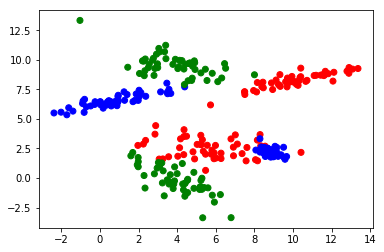

In [11]:
colors = ['red', 'green', 'blue']
plt.scatter(X[:, 0], X[:, 1], c=Y_.flatten(), cmap=ListedColormap(colors))
plt.show()

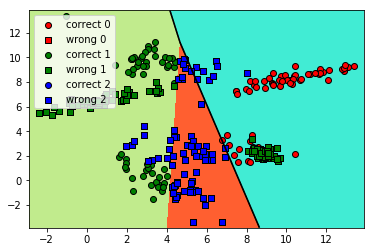

In [12]:
data.plot_decision_boundary(X, lambda x: tflr.classify(x))
# graph the data points
data.graph_data(X, Y_, np.argmax(probs, axis=1))

In [13]:
SEED = 125
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [14]:
X2, Y_2 = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [15]:
Yoh_2 = Y_2.reshape(-1)
Yoh_2 = np.eye(CLASSES)[Yoh_2]

In [16]:
tflr2 = TFLogreg(X2.shape[1], Yoh_2.shape[1], param_delta=0.01, param_lambda=0.01)

In [17]:
tflr2.train(X2, Yoh_2, 50000)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
   0. Loss: 5.59248781
1000. Loss: 0.63682121
2000. Loss: 0.55702358
3000. Loss: 0.50587779
4000. Loss: 0.47076976
5000. Loss: 0.44496199
6000. Loss: 0.42492777
7000. Loss: 0.40873477
8000. Loss: 0.39525494
9000. Loss: 0.38378635
10000. Loss: 0.37386680
11000. Loss: 0.36517680
12000. Loss: 0.35748622
13000. Loss: 0.35062361
14000. Loss: 0.34445736
15000. Loss: 0.33888426
16000. Loss: 0.33382195
17000. Loss: 0.32920307
18000. Loss: 0.32497236
19000. Loss: 0.32108352
20000. Loss: 0.31749770
21000. Loss: 0.31418183
22000. Loss: 0.31110743
23000. Loss: 0.30824998
24000. Loss: 0.30558845
25000. Loss: 0.30310416
26000. Loss: 0.30078080
27000. Loss: 0.29860401
28000. Loss: 0.29656115
29000. Loss: 0.29464093
30000. Loss: 0.29283324
31000. Loss: 0.29112905
32000. Loss: 0.28952044
33000. Loss: 0.28800008
34000. Loss: 0.28656125
35000. Loss: 0.28519818
36000. Loss: 0.28390539
37000. Loss: 0.28267804
38000. Loss: 0.28151152


In [18]:
probs2 = tflr2.eval(X2)

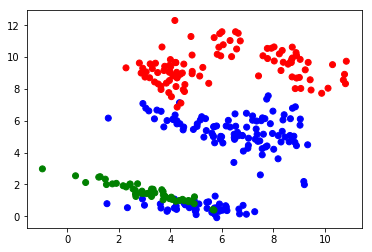

In [19]:
plt.scatter(X2[:, 0], X2[:, 1], c=Y_2.flatten(), cmap=ListedColormap(colors))
plt.show()

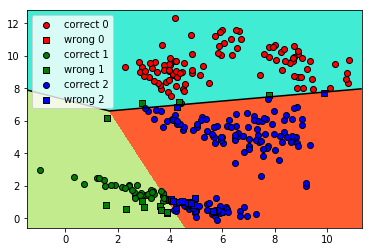

In [20]:
data.plot_decision_boundary(X2, lambda x: tflr2.classify(x))
# graph the data points
data.graph_data(X2, Y_2, np.argmax(probs2, axis=1))

In [21]:
tflr2.eval_perf(np.argmax(probs2, axis=1), np.argmax(Yoh_2, axis=1))

Accuracy: 0.903
Precision: 0.901
Recall: 0.903
F1: 0.902 
